In [1]:
# Install DARTS
%pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 K

In [ ]:
# Mounting GDrive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Sections for importants function
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
import darts.utils.model_selection
from darts.utils.statistics import plot_acf, check_seasonality
from darts.dataprocessing.transformers import Scaler
from datetime import datetime

def read_data(data_path, cols = []):
  return pd.read_csv(data_path, usecols = cols)

def format_df_numbers(df, cols = []):
  result = df.copy(deep=True)
  for col in cols:
    result[col] = result[col].apply(lambda value:float(value.replace(",","")))
  return result

def format_df_date(df, cols = [], date_format = ""):
  result = df.copy(deep=True)
  for col in cols:
    result[col] = result[col].apply(lambda x:datetime.strptime(x, date_format))
  return result

def fill_in_missing_value(series):
  return MissingValuesFiller().transform(series)

def save_series_as_csv(series, save_path):
  series.pd_dataframe().to_csv(save_path)

# Section for trying splitting and saving data back
def splitting_data(series, val_size=0.2, test_size=0.1):
  train_validation, test = darts.utils.model_selection.train_test_split(series, test_size=test_size)
  train, validation = darts.utils.model_selection.train_test_split(train_validation, test_size=val_size)
  train.plot(label='Train')
  validation.plot(label='Validation')
  test.plot(label='Test')
  save_series_as_csv(train, "/content/gdrive/MyDrive/data/train.csv")
  save_series_as_csv(test, "/content/gdrive/MyDrive/data/test.csv")
  save_series_as_csv(validation, "/content/gdrive/MyDrive/data/validation.csv")

def get_sessionals(series, upper_bound, max_lag):
  result = []
  for m in range(2, upper_bound):
    is_seasonal, period = check_seasonality(series, m=m, alpha=1, max_lag=max_lag)
    if is_seasonal:
      result.append(period)
  return result

from darts.metrics import mape, smape, rmse
def calculate_metrics(actual_series, pred_series):
  return (mape(actual_series, pred_series), smape(actual_series, pred_series))


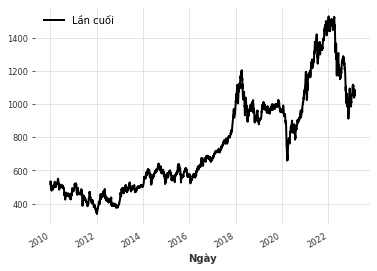

In [5]:
# Loading original data

df = read_data("https://raw.githubusercontent.com/minidragon88/ensemble_forecast/main/data/VN_INDEX_2010_2023.csv", ["Ngày", "Lần cuối"])
# Format value
df = format_df_date(format_df_numbers(df, ["Lần cuối"]), ["Ngày"], '%d/%m/%Y')

# Form a timeseries and fill in missing value
series = fill_in_missing_value(TimeSeries.from_dataframe(df, "Ngày", "Lần cuối", fill_missing_dates=True, freq="D"))
# Add scaler
#series = Scaler().fit_transform(series)
series.plot()
# splitting_data(series, 30, 30)

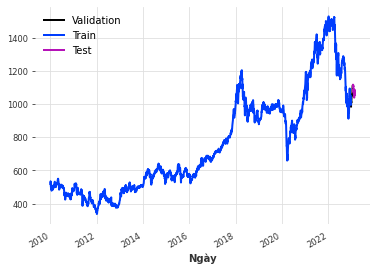

In [6]:
cols = ["Ngày", "Lần cuối"]

base_path = "https://raw.githubusercontent.com/minidragon88/ensemble_forecast/main/data/"
train = TimeSeries.from_dataframe(read_data(base_path + "train.csv", cols), "Ngày", "Lần cuối", fill_missing_dates=True, freq="D")
test = TimeSeries.from_dataframe(read_data(base_path + "test.csv", cols), "Ngày", "Lần cuối", fill_missing_dates=True, freq="D")
validation = TimeSeries.from_dataframe(read_data(base_path + "validation.csv", cols), "Ngày", "Lần cuối", fill_missing_dates=True, freq="D")

validation.plot(label='Validation')
train.plot(label='Train')
test.plot(label='Test')

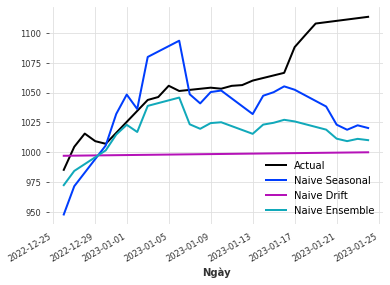

In [7]:
from darts.models.forecasting.baselines import NaiveSeasonal, NaiveDrift, NaiveMean, NaiveEnsembleModel
def get_best_naive_seasonal(train, validation, ranges):
  best = 0;
  current_threshhold = 100
  for counter in range(1, ranges):
    naive_model = NaiveSeasonal(K=counter)
    naive_model.fit(train)
    naive_forecast = naive_model.predict(len(validation))
    mape_val, smape_val = calculate_metrics(naive_forecast, validation)
    if smape_val < current_threshhold:
      best = counter
      current_threshhold = smape_val
  return best

naive_seasonal = NaiveSeasonal(K=get_best_naive_seasonal(train, validation, 200))
naive_seasonal.fit(train)
validation.plot(label='Actual')
naive_seasonal.predict(len(validation)).plot(label='Naive Seasonal')
naive_drift = NaiveDrift()
naive_drift.fit(train)
naive_drift.predict(len(validation)).plot(label='Naive Drift')
naive_ensemble = NaiveEnsembleModel([NaiveSeasonal(K=get_best_naive_seasonal(train, validation, 200)), NaiveDrift()])
naive_ensemble.fit(train)
naive_ensemble.predict(len(validation)).plot(label='Naive Ensemble')

# Get base line
base_mape, base_smape = calculate_metrics(naive_ensemble.predict(len(validation)), validation)

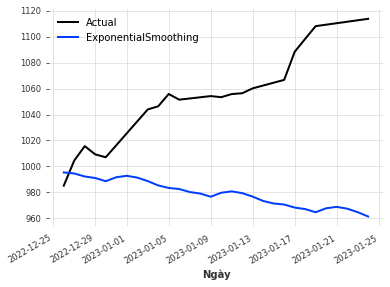

In [8]:
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

exp = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=10, random_state=42)
exp.fit(train)
validation.plot(label='Actual')
exp.predict(len(validation)).plot(label='ExponentialSmoothing')

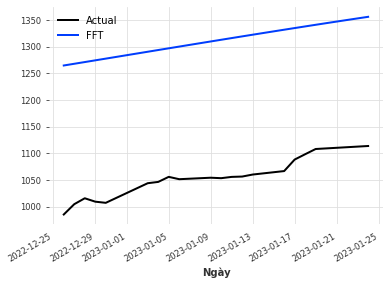

In [9]:
from darts.models.forecasting.fft import FFT
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

exp = FFT(nr_freqs_to_keep=30, required_matches=None, trend='exp', trend_poly_degree=1)
exp.fit(train)
validation.plot(label='Actual')
exp.predict(len(validation)).plot(label='FFT')

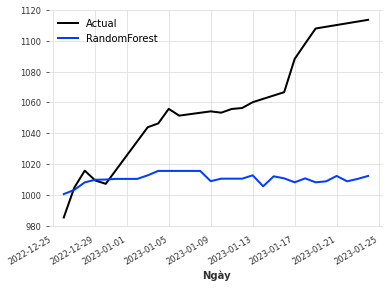

In [10]:
from darts.models.forecasting.random_forest import RandomForest
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

# exp = RandomForest(lags=200, output_chunk_length=10, n_estimators=5)
exp = RandomForest(lags=26, output_chunk_length=1, n_estimators=3)
exp.fit(train)
validation.plot(label='Actual')
exp.predict(len(validation)).plot(label='RandomForest')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.5 M 
---------------------------------------------------
6.5 M     Trainable params
1.6 K     Non-trainable params
6.5 M     Total params
51.864    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

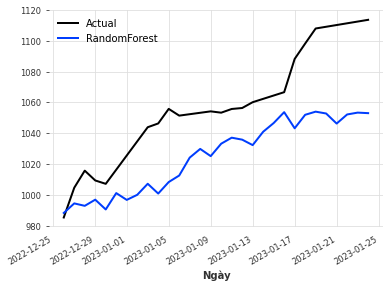

In [ ]:
from darts.models.forecasting.nbeats import NBEATSModel
model = NBEATSModel(
    input_chunk_length=60, output_chunk_length=30, n_epochs=200, random_state=0,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    }
)
model.fit(train)
validation.plot(label='Actual')
model.predict(len(validation)).plot(label='RandomForest')

In [ ]:
import itertools
lags = list(range(10, 30))
# output_chunk_lengths = list(range(1, 20))
n_estimators = list(range(1, 30))
n_estimators = [element * 3 for element in n_estimators]
products = list(itertools.product(lags, n_estimators))

def get_best_random_forest(train, validation, products, base_line):
  best = 0;
  result = []
  for product in products:
    model = RandomForest(lags=product[0], output_chunk_length=1, n_estimators=product[1])
    model.fit(train)
    model_forecast = model.predict(len(validation))
    mape_val, smape_val = calculate_metrics(model_forecast, validation)
    if smape_val < base_line:
      print(product)
      result.append(product)
  return result

result = get_best_random_forest(train, validation, products, base_smape)

(16, 3)
(26, 3)
